<a href="https://colab.research.google.com/github/phelipe-sb/Rain-Prediction/blob/main/Extract_Pickle_File_from_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Get Data from BigQuery**

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np

In [ ]:
# Projett credentials with account service
path = '/content/drive/MyDrive/Weather_Project/Weather Project-6fa8e059f642.json'

In [ ]:
# Credentials
credentials = service_account.Credentials.from_service_account_file(path)
project_id = credentials.project_id
client = bigquery.Client(project=project_id, credentials=credentials)

In [ ]:
# SQL Query that will run in BQ
query_string = """
SELECT *
FROM (SELECT *
            , ROW_NUMBER() OVER(PARTITION BY last_updated, city ORDER BY last_updated, city) AS row_num
            FROM `weather-project-305419.Daily_Weather.Weather-Info`) as row_weather
WHERE row_num = 1
"""

In [ ]:
# Transform sql query results in a pandas dataframe
df = (
    client.query(query_string)
    .result()
    .to_dataframe()
)
df.head()

  last_updated_epoch      last_updated  ... extraction_date row_num
0         1619163900  2021-04-23 03:45  ...            None       1
1         1619160300  2021-04-23 07:45  ...            None       1
2         1619247600  2021-04-24 04:00  ...            None       1
3         1619263800  2021-04-24 07:30  ...            None       1
4         1619272800  2021-04-24 10:00  ...            None       1

[5 rows x 26 columns]


In [ ]:
# Drop useless columns for analysis
df = df.drop(columns=['row_num', 'last_updated_epoch', 'extraction_date'])

In [ ]:
# number of rows and columns
df.shape

(39910, 23)

In [ ]:
# Saving in a pickle file so we don't need query in database again
import pickle
df.to_pickle("weather_data_30-08-2021")

### **2. Analysis/Transformations**

In [ ]:
# Open pickle file
file = open('weather_data_30-08-2021', 'rb')
df = pickle.load(file)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Target: Predict condition (that means wether is raining or not) 
df['condition'].unique()

array(['Overcast', 'Partly cloudy', 'Sunny', 'Light rain', 'Clear',
       'Light rain shower', 'Mist', 'Patchy rain possible', 'Cloudy',
       'Light drizzle', 'Thundery outbreaks possible', 'Heavy rain',
       'Moderate rain', 'Fog', 'Patchy light rain with thunder',
       'Moderate or heavy rain shower', 'Patchy light rain',
       'Torrential rain shower', '1', 'Moderate rain at times',
       'Light snow', 'Moderate or heavy rain with thunder',
       'Moderate or heavy snow with thunder',
       'Moderate or heavy snow showers'], dtype=object)

We need to resume this bunch of conditions and define our target class

In [ ]:
# This conditions means that it's raining in the moment
raining_list = ['Light rain', 'Light rain shower', 'Light drizzle', 'Heavy rain', 'Moderate rain', 'Patchy light rain with thunder'
            , 'Moderate or heavy rain shower', 'Patchy light rain', 'Torrential rain shower', 'Moderate rain at times'
            , 'Moderate or heavy rain with thunder']

In [ ]:
# Creating the target variable
df['target'] = df['condition'].apply(lambda x: 1 if x in raining_list else 0)

array([0, 1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39910 entries, 0 to 39909
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   last_updated  39910 non-null  object
 1   temp_c        39910 non-null  object
 2   temp_f        39910 non-null  object
 3   is_day        39910 non-null  object
 4   condition     39910 non-null  object
 5   wind_mph      39910 non-null  object
 6   wind_kph      39910 non-null  object
 7   wind_degree   39910 non-null  object
 8   wind_dir      39910 non-null  object
 9   pressure_mb   39910 non-null  object
 10  pressure_in   39910 non-null  object
 11  precip_mm     39910 non-null  object
 12  precip_in     39910 non-null  object
 13  humidity      39910 non-null  object
 14  cloud         39910 non-null  object
 15  feelslike_c   39910 non-null  object
 16  feelslike_f   39910 non-null  object
 17  vis_km        39910 non-null  object
 18  vis_miles     39910 non-null  object
 19  uv  

In [ ]:
# Create a list with columns to be converted
float_list = list()
for column_name in df.drop(columns='target').columns:
  if str(df[f'{column_name}'][0]).replace(".", "").isnumeric() == True:
    float_list.append(column_name)

In [ ]:
# function to convert columns to float
def to_float(df):
  for column in df.columns:
    if column in float_list:
      df[f'{column}'] = df[f'{column}'].astype("float")
  return df.info()

In [ ]:
to_float(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39910 entries, 0 to 39909
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   last_updated  39910 non-null  object 
 1   temp_c        39910 non-null  float64
 2   temp_f        39910 non-null  float64
 3   is_day        39910 non-null  float64
 4   condition     39910 non-null  object 
 5   wind_mph      39910 non-null  float64
 6   wind_kph      39910 non-null  float64
 7   wind_degree   39910 non-null  float64
 8   wind_dir      39910 non-null  object 
 9   pressure_mb   39910 non-null  float64
 10  pressure_in   39910 non-null  float64
 11  precip_mm     39910 non-null  float64
 12  precip_in     39910 non-null  float64
 13  humidity      39910 non-null  float64
 14  cloud         39910 non-null  float64
 15  feelslike_c   39910 non-null  float64
 16  feelslike_f   39910 non-null  float64
 17  vis_km        39910 non-null  float64
 18  vis_miles     39910 non-nu

percentage of target == 1 is: 10.0%


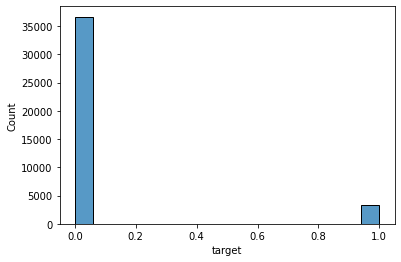

In [ ]:
# Target Variable Ocurrency
percent = str(round(sum(df['target'])/len(df['target']), 1)*100) + '%'
print(f'percentage of target == 1 is: {percent}')
sns.histplot(data=df['target'])

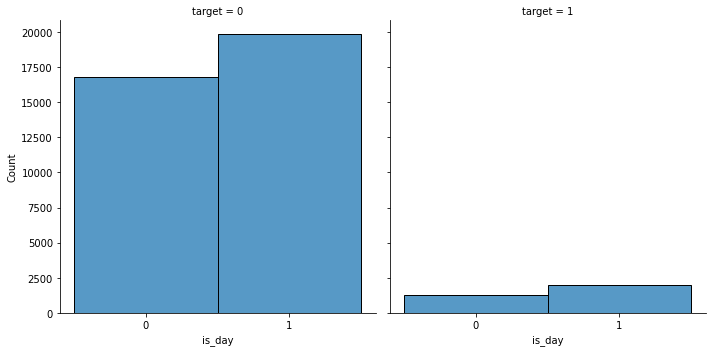

In [ ]:
sns.displot(x=df['is_day'], col=df['target'])

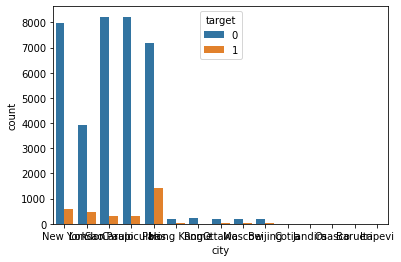

In [ ]:
sns.countplot(x=df['city'], hue=df['target'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39910 entries, 0 to 39909
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   last_updated  39910 non-null  object
 1   temp_c        39910 non-null  object
 2   temp_f        39910 non-null  object
 3   is_day        39910 non-null  object
 4   condition     39910 non-null  object
 5   wind_mph      39910 non-null  object
 6   wind_kph      39910 non-null  object
 7   wind_degree   39910 non-null  object
 8   wind_dir      39910 non-null  object
 9   pressure_mb   39910 non-null  object
 10  pressure_in   39910 non-null  object
 11  precip_mm     39910 non-null  object
 12  precip_in     39910 non-null  object
 13  humidity      39910 non-null  object
 14  cloud         39910 non-null  object
 15  feelslike_c   39910 non-null  object
 16  feelslike_f   39910 non-null  object
 17  vis_km        39910 non-null  object
 18  vis_miles     39910 non-null  object
 19  uv  

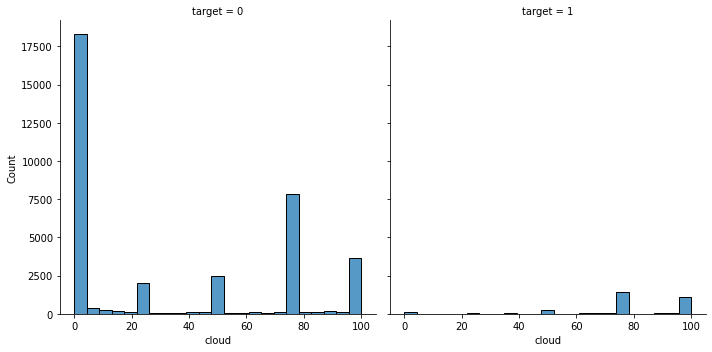

In [ ]:
sns.displot(x=df['cloud'], col=df['target'])